###  **Custom Dataset Class**

You define your dataset by subclassing `torch.utils.data.Dataset` and overriding `__len__()` and `__getitem__()`.

```python
import torch
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data  # e.g., a NumPy array or tensor
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        return x, y
```

---

###  **ImageFolder**

---

points_2d.shape torch.Size([20000, 2])
Mean: tensor([ 0.0009, -0.0052], device='cuda:0')
Std: tensor([2.8822, 2.8786], device='cuda:0')
Label mean: tensor(1.5365e+09, device='cuda:0')
Label std: tensor(7.3382e+09, device='cuda:0')


/home/behnam/anaconda3/envs/PyTorchTutorial/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0, Train Loss: 0.847783, Val Loss: 0.714771, LR: 0.010000
Epoch 10, Train Loss: 0.341598, Val Loss: 0.327056, LR: 0.010000
Epoch 20, Train Loss: 0.193932, Val Loss: 0.134692, LR: 0.005000
Epoch 30, Train Loss: 0.182786, Val Loss: 0.050926, LR: 0.002500
Epoch 40, Train Loss: 0.136256, Val Loss: 4.112852, LR: 0.001250
Early stopping at epoch 45
Final Test Loss (denormalized): 33543942240905691136.000000


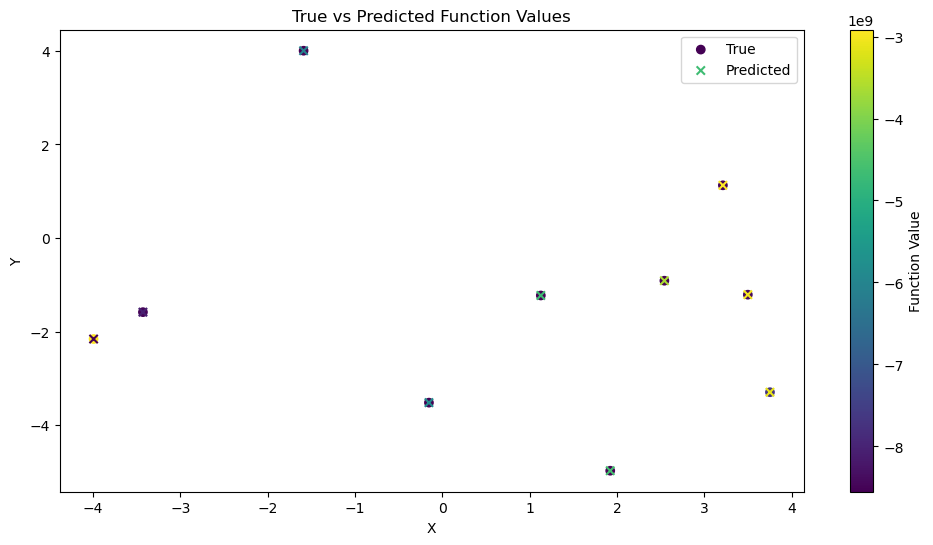

In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data
from torchvision import datasets, transforms, utils
from torch.utils.data import random_split

import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Problem: Setting torch.set_default_tensor_type('torch.cuda.FloatTensor') forces everything to CUDA float tensors by default.
# This can break a lot of libraries like torchvision.transforms, or anything that assumes default CPU tensors.

# torch.set_default_tensor_type('torch.cuda.FloatTensor')
# torch.set_default_device(device)


def custom_function_np(x, y):
    return np.exp(x**2) + np.cos(y**2)


def custom_function(x, y):
    return torch.exp(x**2) + torch.cos(y**2)


class FunctionModel(nn.Module):
    def __init__(self, input_dim=2, hidden_dims=[64, 32, 16], output_dim=1):
        super(FunctionModel, self).__init__()
        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_dim))
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


class CustomDataset(data.Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, label


g = torch.Generator(device=device)
g.manual_seed(42)

low = -5
high = 5
samples = 20000
points_2d = torch.rand(size=(samples, 2), generator=g,
                       device=device) * (high - low) + low


# labels = custom_function_np(points_2d[:, 0].detach().cpu(
# ).numpy(), points_2d[:, 1].detach().cpu().numpy())

labels = custom_function(points_2d[:, 0], points_2d[:, 1])
print("points_2d.shape", points_2d.shape)


# x_np = points_2d[:, 0].detach().cpu().numpy()
# y_np = points_2d[:, 1].detach().cpu().numpy()
# z_np = labels.detach().cpu().numpy()

# # Create the 3D plot
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')

# # Tri-Surface plot of the points
# ax.plot_trisurf(x_np, y_np, z_np,
#                 linewidth=0.2, antialiased=True)

# # Add labels and title
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z (Ackley Function Value)')
# ax.set_title('3D Surface Plot of Custom Function Values')

# # Show the plot
# plt.show()


# Uncomment and use normalization
mean = points_2d.mean(axis=0)
std = points_2d.std(axis=0)

print("Mean:", mean)
print("Std:", std)

# Normalize the data
points_2d = (points_2d - mean) / std

# Also normalize the labels
label_mean = labels.mean()
label_std = labels.std()
labels = (labels - label_mean) / label_std

print("Label mean:", label_mean)
print("Label std:", label_std)


# data_transforms = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=mean, std=std),
# ])


full_dataset = CustomDataset(
    data=points_2d, labels=labels, transform=None)


# Define split sizes
train_size = int(0.7 * len(full_dataset))   # 70%
val_size = int(0.15 * len(full_dataset))     # 15%
test_size = len(full_dataset) - train_size - val_size  # Remaining 15%

# Randomly split
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size])


train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = data.DataLoader(test_dataset, batch_size=32, shuffle=False)


model = FunctionModel().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Training loop with validation
num_epochs = 100
best_val_loss = float('inf')
patience = 15
patience_counter = 0

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_losses = []
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs.squeeze(-1), batch_y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    avg_train_loss = sum(train_losses) / len(train_losses)

    # Validation phase
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            outputs = model(batch_x)
            loss = criterion(outputs.squeeze(-1), batch_y)
            val_losses.append(loss.item())

    avg_val_loss = sum(val_losses) / len(val_losses)

    # Learning rate scheduling
    scheduler.step(avg_val_loss)

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

    if epoch % 10 == 0:
        print(
            f"Epoch {epoch}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

# Test phase
model.eval()
test_losses = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        outputs = model(batch_x)
        # Denormalize predictions and targets for final evaluation
        outputs_denorm = outputs.squeeze(-1) * label_std + label_mean
        batch_y_denorm = batch_y * label_std + label_mean
        loss = criterion(outputs_denorm, batch_y_denorm)
        test_losses.append(loss.item())

avg_test_loss = sum(test_losses) / len(test_losses)
print(f"Final Test Loss (denormalized): {avg_test_loss:.6f}")

# Visualize some predictions
model.eval()
with torch.no_grad():
    # Get a batch of test data
    test_batch_x, test_batch_y = next(iter(test_loader))
    predictions = model(test_batch_x).squeeze(-1)

    # Denormalize
    test_batch_x_denorm = test_batch_x * std + mean
    predictions_denorm = predictions * label_std + label_mean
    test_batch_y_denorm = test_batch_y * label_std + label_mean

    # Plot first 10 samples
    plt.figure(figsize=(12, 6))
    plt.scatter(test_batch_x_denorm[:10, 0].cpu(), test_batch_x_denorm[:10, 1].cpu(),
                c=test_batch_y_denorm[:10].cpu(), cmap='viridis', label='True')
    plt.scatter(test_batch_x_denorm[:10, 0].cpu(), test_batch_x_denorm[:10, 1].cpu(),
                c=predictions_denorm[:10].cpu(), cmap='viridis', marker='x', label='Predicted')
    plt.colorbar(label='Function Value')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('True vs Predicted Function Values')
    plt.legend()
    plt.show()
